In [48]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats import t

import seaborn as sns
from sklearn import tree
from sklearn import datasets
from sklearn.datasets import make_moons ## sklearn functions for synthetic data
from sklearn.datasets import make_circles
from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA  ## sklearn PCA classes
from sklearn.decomposition import KernelPCA
from sklearn import linear_model    ## sklearn linear model
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier ## sklearn decision trees
from sklearn.ensemble import RandomForestClassifier ## sklearn random forests
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from IPython.display import Image
import pydotplus
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
pd.reset_option('all')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [49]:
# read Fire_Incident_Dispatch_Data_With_Loc.csv
Dispatch = pd.read_csv('Fire_Incident_Dispatch_Data_Pop_Weather.csv')
pd.set_option('display.max_columns', None)
Dispatch['INCIDENT_DATETIME'] = pd.to_datetime(Dispatch['INCIDENT_DATETIME'])

### Filter only INCIDENT_CLASSIFICATION_GROUP == 'Structural Fires' or 'NonStructural Fires'

In [50]:
# filter only INCIDENT_CLASSIFICATION_GROUP = 'Structural Fires' or 'NonStructural Fires'
Dispatch1 = Dispatch[(Dispatch.INCIDENT_CLASSIFICATION_GROUP == 'Structural Fires') | (Dispatch.INCIDENT_CLASSIFICATION_GROUP == 'NonStructural Fires')]
# construct the target variable, ResolutionTime
Dispatch1['INCIDENT_CLOSE_DATETIME']=pd.to_datetime(Dispatch1['INCIDENT_CLOSE_DATETIME'])
Dispatch1['INCIDENT_DATETIME'] = pd.to_datetime(Dispatch1['INCIDENT_DATETIME'])
Dispatch1['FIRST_ON_SCENE_DATETIME'] = pd.to_datetime(Dispatch1['FIRST_ON_SCENE_DATETIME'])

Dispatch1['ResolutionTime'] = Dispatch1['INCIDENT_CLOSE_DATETIME']-Dispatch1['FIRST_ON_SCENE_DATETIME']
#加入变量：INCIDENT_TRAVEL_TM_SECONDS_QY，DISPATCH_RESPONSE_SECONDS_QY
Dispatch1['ResolutionTime'] = Dispatch1['ResolutionTime'].dt.total_seconds()

In [51]:
# drop the unuseful columns, split the INCIDENT_DATETIME and add weekday
Dispatch2 = Dispatch1.drop(['Unnamed: 0','STARFIRE_INCIDENT_ID','ALARM_BOX_NUMBER','ALARM_BOX_BOROUGH','ALARM_BOX_LOCATION',
                            'INCIDENT_BOROUGH','POLICEPRECINCT','CITYCOUNCILDISTRICT','COMMUNITYDISTRICT','COMMUNITYSCHOOLDISTRICT',
                            'ALARM_LEVEL_INDEX_DESCRIPTION','ALARM_SOURCE_DESCRIPTION_TX',
                            #'LATITUDE','LONGITUDE',
                            'INCIDENT_DATETIME','ZIPCODE',
                            'INCIDENT_CLASSIFICATION_GROUP',
                            'MinTemperature',
                            'FIRST_ASSIGNMENT_DATETIME','FIRST_ACTIVATION_DATETIME','INCIDENT_RESPONSE_SECONDS_QY',
                            'INCIDENT_CLOSE_DATETIME','VALID_DISPATCH_RSPNS_TIME_INDC','VALID_INCIDENT_RSPNS_TIME_INDC',
                            ],axis=1)

In [52]:
Dispatch2['weekday'] = Dispatch2['FIRST_ON_SCENE_DATETIME'].dt.weekday
Dispatch2['hour'] = Dispatch2['FIRST_ON_SCENE_DATETIME'].dt.hour

In [53]:
Dispatch2

,CONGRESSIONALDISTRICT,HIGHEST_ALARM_LEVEL,INCIDENT_CLASSIFICATION,DISPATCH_RESPONSE_SECONDS_QY,FIRST_ON_SCENE_DATETIME,INCIDENT_TRAVEL_TM_SECONDS_QY,ENGINES_ASSIGNED_QUANTITY,LADDERS_ASSIGNED_QUANTITY,OTHER_UNITS_ASSIGNED_QUANTITY,LATITUDE,LONGITUDE,POP100,MaxTemperature,AvgTemperature,Precipitation,ResolutionTime,weekday,hour
7,NaN,First Alarm,Demolition Debris or Rubbish Fire,75.0,2021-02-07 02:42:00,244.0,1.0,0.0,0.0,40.729553,-73.989900,215.929626,40,32.0,0.39,120.0,6.0,2.0
51,12.0,First Alarm,Demolition Debris or Rubbish Fire,32.0,NaT,0.0,1.0,0.0,0.0,40.729553,-73.989900,215.929626,83,75.0,0,NaN,NaN,NaN
57,12.0,First Alarm,Automobile Fire,38.0,2020-08-01 04:25:48,187.0,1.0,1.0,0.0,40.729553,-73.989900,215.929626,88,79.5,0,2551.0,5.0,4.0
77,12.0,First Alarm,Other Commercial Building Fire,24.0,2020-10-22 21:42:32,149.0,3.0,2.0,1.0,40.729553,-73.989900,215.929626,68,66.0,0,967.0,3.0,21.0
93,12.0,First Alarm,Multiple Dwelling 'A' - Food on the stove fire,37.0,2020-01-17 22:05:47,85.0,4.0,2.0,1.0,40.729553,-73.989900,215.929626,33,27.0,0,1746.0,4.0,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615907,6.0,First Alarm,Demolition Debris or Rubbish Fire,32.0,2022-07-30 23:24:26,316.0,1.0,0.0,0.0,40.743107,-73.815676,7.540075,87,80.0,T,319.0,5.0,23.0
1615935,13.0,First Alarm,Automobile Fire,50.0,2023-10-20 19:52:44,326.0,1.0,1.0,0.0,40.789511,-73.937502,0.000000,63,61.0,0.84,2768.0,4.0,19.0
1615985,11.0,First Alarm,Private Dwelling Fire,38.0,2023-07-31 13:30:22,218.0,4.0,2.0,1.0,40.541210,-74.155249,33.057411,85,75.5,0,4270.0,0.0,13.0
1616020,14.0,First Alarm,Brush Fire,18.0,2023-05-07 17:05:19,288.0,1.0,0.0,0.0,40.767853,-73.883238,15.644019,78,66.0,0.02,1071.0,6.0,17.0


In [54]:
# for Precipitation (according to https://www.weather.gov/climateservices/nowdatafaq)
# M - Means that the data is missing.  This can happen for a variety of reasons including the data did not make a quality check, there was an equipment outage, or even the observer was not available at a manual station.
# T - This means that only a trace of precipitation has fallen.  Trace is defined as less than the smallest measurable amount.  That threshold is below for the different precipitation measurements;
#      Liquid precipitation (rain, showers) - Less than 0.005"
#      Snowfall - Less than 0.05"
#      Snow depth on the ground - Less than 0.5"

In [55]:
# so we can T with 0.005, and convert data type to float
Dispatch2['Precipitation'] = Dispatch2['Precipitation'].replace(' T',0.005)
Dispatch2['Precipitation'] = Dispatch2['Precipitation'].astype(float)
Dispatch3 = Dispatch2.drop('FIRST_ON_SCENE_DATETIME',axis=1)
# check na values
print(Dispatch3.isnull().sum())

CONGRESSIONALDISTRICT            1344
HIGHEST_ALARM_LEVEL                 0
INCIDENT_CLASSIFICATION             0
DISPATCH_RESPONSE_SECONDS_QY       25
INCIDENT_TRAVEL_TM_SECONDS_QY     670
ENGINES_ASSIGNED_QUANTITY          29
LADDERS_ASSIGNED_QUANTITY          29
OTHER_UNITS_ASSIGNED_QUANTITY      29
LATITUDE                            0
LONGITUDE                           0
POP100                              0
MaxTemperature                      0
AvgTemperature                      0
Precipitation                       0
ResolutionTime                   1712
weekday                          1708
hour                             1708
dtype: int64


In [56]:
# since the number of missing values is small, we can drop them
Dispatch3 = Dispatch3.dropna()
Dispatch3.shape

(96689, 17)

### Feature importance

#### 1. Use Tree Based Models (decision tree, random forest and XGBoost) to get feature importance, with categorical features label-encoded

In [57]:
# we first try decision tree and random forest to see the feature importance
X = Dispatch3.drop(['ResolutionTime'],axis=1)
y = Dispatch3['ResolutionTime']

In [58]:
# the categorical variables are INCIDENT_BOROUGH, CONGRESSIONALDISTRICT, ALARM_SOURCE_DESCRIPTION_TX, HIGHEST_ALARM_LEVEL, INCIDENT_CLASSIFICATION, INCIDENT_CLASSIFICATION_GROUP.

# Among them, HIGHEST_ALARM_LEVEL is the only ordinal variable. According to https://fdnewyork.com//aa.asp , first alarm is the lowest level
#       And according to https://www.nycfire.net/forums/threads/4-30-22-manhattan-5th-alarm-box-0143.70772/page-2, "Simultaneous Call" maybe above 5th alarm
#       11.9 Additional Alarms Beyond a Fifth Alarm
#       11.9.1 After the regular assignments of a street box have been exhausted, additional engine companies may be called by the use of a Simultaneous Call or Borough Call.

# we can use LabelEncoder to encode most categorical variables
le = preprocessing.LabelEncoder()
X2 = X.copy()
X2['CONGRESSIONALDISTRICT'] = le.fit_transform(X2['CONGRESSIONALDISTRICT'])
X2['INCIDENT_CLASSIFICATION'] = le.fit_transform(X2['INCIDENT_CLASSIFICATION'])

In [59]:
# for HIGHEST_ALARM_LEVEL, we can use the ordinal values
alarm_level_mapping = {
    'First Alarm': '1',
    'All Hands Working': '2',
    'Second Alarm': '3',
    'Third Alarm': '4',
    'Fourth Alarm': '5',
    'Fifth Alarm': '6',
    'Fifth Alarm or Higher': '7',
    'Simultaneous Call': '8',
    'Sixth Alarm': '9',
    'Seventh Alarm': '10',
    'Eighth Alarm': '11',
    'Ninth Alarm or Higher': '12'
}

X2['HIGHEST_ALARM_LEVEL'] = X2['HIGHEST_ALARM_LEVEL'].replace(alarm_level_mapping)

In [60]:
X2['HIGHEST_ALARM_LEVEL'] = X2['HIGHEST_ALARM_LEVEL'].astype(int)

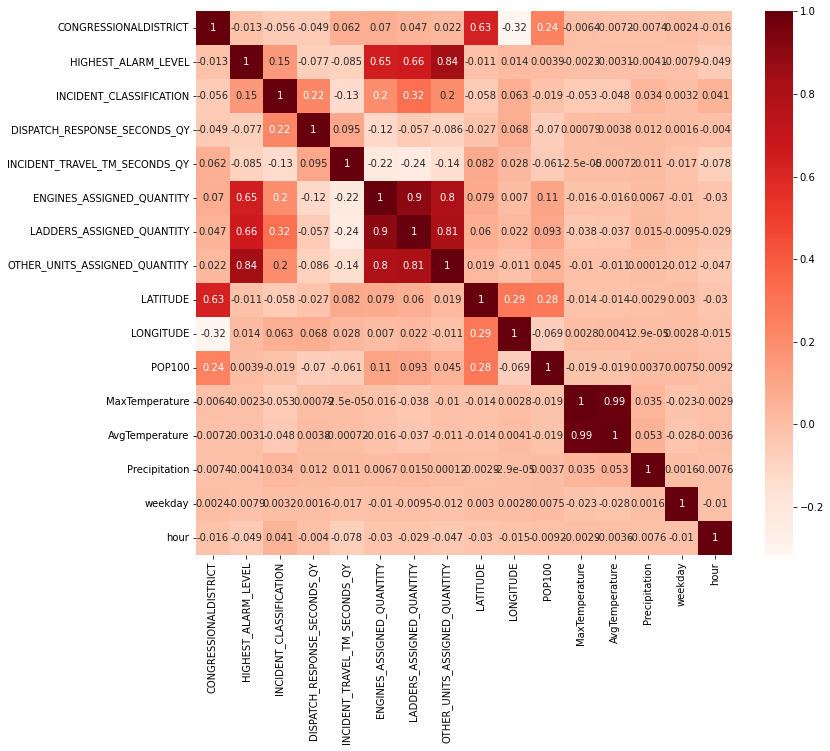

In [61]:
# check the correlation between features
plt.figure(figsize=(12,10))
cor = X2.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [62]:
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot

In [63]:
# try CART (decision tree) to see the feature importance
model_CART = DecisionTreeRegressor()
model_CART.fit(X2, y)
importance_CART = model_CART.feature_importances_

CART Feature Importance:
Feature 0: CONGRESSIONALDISTRICT, Score: 0.00277
Feature 1: HIGHEST_ALARM_LEVEL, Score: 0.03806
Feature 2: INCIDENT_CLASSIFICATION, Score: 0.01014
Feature 3: DISPATCH_RESPONSE_SECONDS_QY, Score: 0.01907
Feature 4: INCIDENT_TRAVEL_TM_SECONDS_QY, Score: 0.01752
Feature 5: ENGINES_ASSIGNED_QUANTITY, Score: 0.44976
Feature 6: LADDERS_ASSIGNED_QUANTITY, Score: 0.01203
Feature 7: OTHER_UNITS_ASSIGNED_QUANTITY, Score: 0.20948
Feature 8: LATITUDE, Score: 0.09058
Feature 9: LONGITUDE, Score: 0.03144
Feature 10: POP100, Score: 0.06565
Feature 11: MaxTemperature, Score: 0.00798
Feature 12: AvgTemperature, Score: 0.01098
Feature 13: Precipitation, Score: 0.01046
Feature 14: weekday, Score: 0.00355
Feature 15: hour, Score: 0.02053


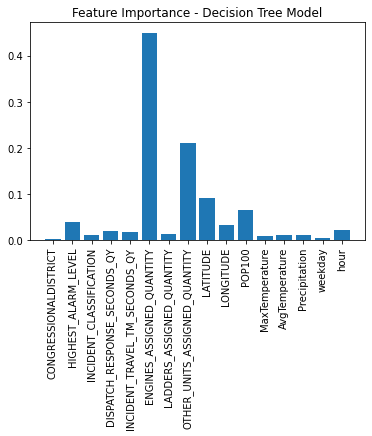

In [64]:
# summarize feature importance
print('CART Feature Importance:')
for i, (feature_name, importance_score) in enumerate(zip(X2.columns, importance_CART)):
    print(f'Feature {i}: {feature_name}, Score: {importance_score:.5f}')

# plot feature importance, descending
pyplot.bar(range(len(importance_CART)), importance_CART)
pyplot.xticks(range(len(importance_CART)), X2.columns, rotation='vertical')
pyplot.title('Feature Importance - Decision Tree Model')
pyplot.show()

In [65]:
# use random forest to calculate the feature importance
model_rf = RandomForestRegressor()
model_rf.fit(X2, y)
importance_rf = model_rf.feature_importances_

Random Forest Feature Importance:
Feature 0: CONGRESSIONALDISTRICT, Score: 0.00563
Feature 1: HIGHEST_ALARM_LEVEL, Score: 0.02807
Feature 2: INCIDENT_CLASSIFICATION, Score: 0.02215
Feature 3: DISPATCH_RESPONSE_SECONDS_QY, Score: 0.01646
Feature 4: INCIDENT_TRAVEL_TM_SECONDS_QY, Score: 0.02803
Feature 5: ENGINES_ASSIGNED_QUANTITY, Score: 0.49323
Feature 6: LADDERS_ASSIGNED_QUANTITY, Score: 0.01745
Feature 7: OTHER_UNITS_ASSIGNED_QUANTITY, Score: 0.16676
Feature 8: LATITUDE, Score: 0.07996
Feature 9: LONGITUDE, Score: 0.03487
Feature 10: POP100, Score: 0.03050
Feature 11: MaxTemperature, Score: 0.01542
Feature 12: AvgTemperature, Score: 0.01608
Feature 13: Precipitation, Score: 0.00863
Feature 14: weekday, Score: 0.01596
Feature 15: hour, Score: 0.02078


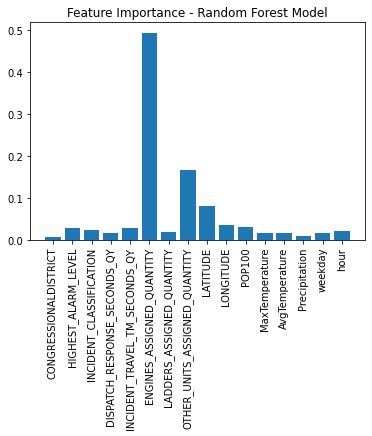

In [66]:
print('Random Forest Feature Importance:')
for i, (feature_name, importance_score) in enumerate(zip(X2.columns, importance_rf)):
    print(f'Feature {i}: {feature_name}, Score: {importance_score:.5f}')

# plot feature importance
pyplot.bar(range(len(importance_rf)), importance_rf)
pyplot.xticks(range(len(importance_rf)), X2.columns, rotation='vertical')
pyplot.title('Feature Importance - Random Forest Model')
pyplot.show()

In [67]:
# XGBoost
import xgboost
from xgboost import XGBRegressor
model_xgb = XGBRegressor()
model_xgb.fit(X2, y)
importance_xgb = model_xgb.feature_importances_

XGBoost Feature Importance:
Feature 0: CONGRESSIONALDISTRICT, Score: 0.01596
Feature 1: HIGHEST_ALARM_LEVEL, Score: 0.15045
Feature 2: INCIDENT_CLASSIFICATION, Score: 0.01964
Feature 3: DISPATCH_RESPONSE_SECONDS_QY, Score: 0.00738
Feature 4: INCIDENT_TRAVEL_TM_SECONDS_QY, Score: 0.01220
Feature 5: ENGINES_ASSIGNED_QUANTITY, Score: 0.39743
Feature 6: LADDERS_ASSIGNED_QUANTITY, Score: 0.02243
Feature 7: OTHER_UNITS_ASSIGNED_QUANTITY, Score: 0.13331
Feature 8: LATITUDE, Score: 0.05261
Feature 9: LONGITUDE, Score: 0.02903
Feature 10: POP100, Score: 0.00801
Feature 11: MaxTemperature, Score: 0.01150
Feature 12: AvgTemperature, Score: 0.02031
Feature 13: Precipitation, Score: 0.01879
Feature 14: weekday, Score: 0.06907
Feature 15: hour, Score: 0.03188


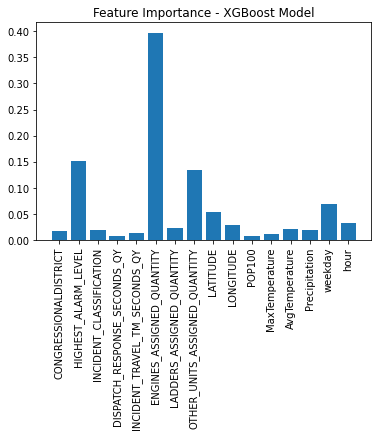

In [68]:
print('XGBoost Feature Importance:')
for i, (feature_name, importance_score) in enumerate(zip(X2.columns, importance_xgb)):
    print(f'Feature {i}: {feature_name}, Score: {importance_score:.5f}')

# plot feature importance
pyplot.bar(range(len(importance_xgb)), importance_xgb)
pyplot.xticks(range(len(importance_xgb)), X2.columns, rotation='vertical')
pyplot.title('Feature Importance - XGBoost Model')
pyplot.show()

In [69]:
Dispatch3.to_csv("data.csv",index=False)

#### 2. Use non-tree based models (Linear, Lasso) to get feature importance, with categorical features one-hot encoded

In [70]:
X3 = X.copy()

In [71]:
# but for highest alarm level, we still use ordinal values
X3['HIGHEST_ALARM_LEVEL'] = X3['HIGHEST_ALARM_LEVEL'].replace(alarm_level_mapping)
X3['HIGHEST_ALARM_LEVEL'] = X3['HIGHEST_ALARM_LEVEL'].astype(int)

In [72]:
# use OneHotEncoder for INCIDENT_BOROUGH, CONGRESSIONALDISTRICT, ALARM_SOURCE_DESCRIPTION_TX, INCIDENT_CLASSIFICATION, INCIDENT_CLASSIFICATION_GROUP
categorical_cols = ['CONGRESSIONALDISTRICT','INCIDENT_CLASSIFICATION']

# Initialize OneHotEncoder
onehotencoder = preprocessing.OneHotEncoder()

X3_encoded = onehotencoder.fit_transform(X3[categorical_cols]).toarray()
X3_encoded = pd.DataFrame(X3_encoded, columns=onehotencoder.get_feature_names_out(categorical_cols))

X3.reset_index(drop=True, inplace=True)
X3_encoded.reset_index(drop=True, inplace=True)

X3 = pd.concat([X3, X3_encoded], axis=1)
X3 = X3.drop(categorical_cols, axis=1)

X3

,HIGHEST_ALARM_LEVEL,DISPATCH_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,ENGINES_ASSIGNED_QUANTITY,LADDERS_ASSIGNED_QUANTITY,OTHER_UNITS_ASSIGNED_QUANTITY,LATITUDE,LONGITUDE,POP100,MaxTemperature,AvgTemperature,Precipitation,weekday,hour,CONGRESSIONALDISTRICT_3.0,CONGRESSIONALDISTRICT_5.0,CONGRESSIONALDISTRICT_6.0,CONGRESSIONALDISTRICT_7.0,CONGRESSIONALDISTRICT_8.0,CONGRESSIONALDISTRICT_9.0,CONGRESSIONALDISTRICT_10.0,CONGRESSIONALDISTRICT_11.0,CONGRESSIONALDISTRICT_12.0,CONGRESSIONALDISTRICT_13.0,CONGRESSIONALDISTRICT_14.0,CONGRESSIONALDISTRICT_15.0,CONGRESSIONALDISTRICT_16.0,INCIDENT_CLASSIFICATION_Abandoned Derelict Vehicle Fire,INCIDENT_CLASSIFICATION_Automobile Fire,INCIDENT_CLASSIFICATION_Brush Fire,INCIDENT_CLASSIFICATION_Church Fire,INCIDENT_CLASSIFICATION_Construction or Demolition Building Fire,INCIDENT_CLASSIFICATION_Demolition Debris or Rubbish Fire,INCIDENT_CLASSIFICATION_Factory Fire,INCIDENT_CLASSIFICATION_Hospital Fire,INCIDENT_CLASSIFICATION_Manhole Fire - Blown Cover,INCIDENT_CLASSIFICATION_Manhole Fire - Extended to Building,INCIDENT_CLASSIFICATION_Manhole Fire - Other,INCIDENT_CLASSIFICATION_Manhole Fire - Seeping Smoke,INCIDENT_CLASSIFICATION_Maritime Fire,INCIDENT_CLASSIFICATION_Multiple Dwelling 'A' - Compactor fire,INCIDENT_CLASSIFICATION_Multiple Dwelling 'A' - Food on the stove fire,INCIDENT_CLASSIFICATION_Multiple Dwelling 'A' - Other fire,INCIDENT_CLASSIFICATION_Multiple Dwelling 'B' Fire,INCIDENT_CLASSIFICATION_Other Commercial Building Fire,INCIDENT_CLASSIFICATION_Other Public Building Fire,INCIDENT_CLASSIFICATION_Other Transportation Fire,INCIDENT_CLASSIFICATION_Private Dwelling Fire,INCIDENT_CLASSIFICATION_School Fire,INCIDENT_CLASSIFICATION_Store Fire,INCIDENT_CLASSIFICATION_Theater or TV Studio Fire,INCIDENT_CLASSIFICATION_Transit System - NonStructural,INCIDENT_CLASSIFICATION_Transit System - Structural,INCIDENT_CLASSIFICATION_Under Contruction / Vacant Fire,INCIDENT_CLASSIFICATION_Untenanted Building Fire
0,1,38.0,187.0,1.0,1.0,0.0,40.729553,-73.989900,215.929626,88,79.5,0.000,5.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,24.0,149.0,3.0,2.0,1.0,40.729553,-73.989900,215.929626,68,66.0,0.000,3.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,37.0,85.0,4.0,2.0,1.0,40.729553,-73.989900,215.929626,33,27.0,0.000,4.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,61.0,267.0,1.0,1.0,0.0,40.729553,-73.989900,215.929626,61,52.0,0.005,1.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,19.0,109.0,4.0,2.0,1.0,40.729553,-73.989900,215.929626,45,41.0,0.370,4.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96684,1,37.0,333.0,1.0,0.0,0.0,40.716017,-73.886351,2.001191,46,41.0,0.000,5.0,18.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96685,1,32.0,316.0,1.0,0.0,0.0,40.743107,-73.815676,7.540075,87,80.0,0.005,5.0,23.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96686,1,50.0,326.0,1.0,1.0,0.0,40.789511,-73.937502,0.000000,63,61.0,0.

In [73]:
# first try linear regression to see feature importance
from sklearn.linear_model import LinearRegression
model_lr = LinearRegression()
model_lr.fit(X3, y)
importance_lr = model_lr.coef_

Linear Regression Feature Importance - top 30:
Feature 0: INCIDENT_CLASSIFICATION_Under Contruction / Vacant Fire, Score: 6440.40228
Feature 1: INCIDENT_CLASSIFICATION_Construction or Demolition Building Fire, Score: -2790.85775
Feature 2: HIGHEST_ALARM_LEVEL, Score: 2285.21567
Feature 3: INCIDENT_CLASSIFICATION_Other Transportation Fire, Score: 2182.44624
Feature 4: INCIDENT_CLASSIFICATION_Untenanted Building Fire, Score: -2118.94300
Feature 5: LATITUDE, Score: 1946.43066
Feature 6: INCIDENT_CLASSIFICATION_Automobile Fire, Score: 1891.31651
Feature 7: LONGITUDE, Score: -1878.23000
Feature 8: INCIDENT_CLASSIFICATION_Multiple Dwelling 'B' Fire, Score: -1747.68792
Feature 9: INCIDENT_CLASSIFICATION_Abandoned Derelict Vehicle Fire, Score: 1738.01521
Feature 10: INCIDENT_CLASSIFICATION_Hospital Fire, Score: -1683.53165
Feature 11: INCIDENT_CLASSIFICATION_Church Fire, Score: -1624.21738
Feature 12: INCIDENT_CLASSIFICATION_School Fire, Score: -1510.82580
Feature 13: INCIDENT_CLASSIFICATION_T

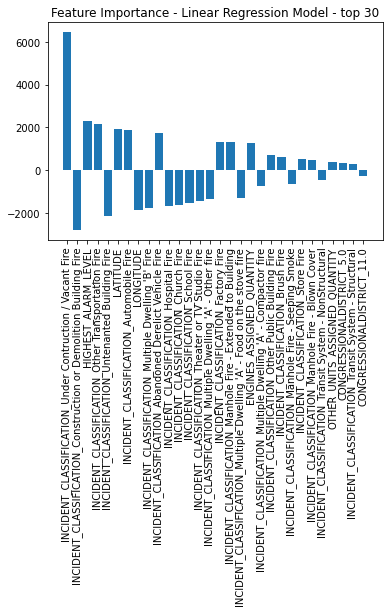

In [74]:
# feature importance, only show the top 30 features
print('Linear Regression Feature Importance - top 30:')
importance_lr_abs = np.abs(importance_lr)
importance_lr_idx = np.argsort(importance_lr_abs)[::-1]
for i in range(30):
    print(f'Feature {i}: {X3.columns[importance_lr_idx[i]]}, Score: {importance_lr[importance_lr_idx[i]]:.5f}')

# plot feature importance
pyplot.bar(range(30), importance_lr[importance_lr_idx[:30]])
pyplot.xticks(range(30), X3.columns[importance_lr_idx[:30]], rotation='vertical')
pyplot.title('Feature Importance - Linear Regression Model - top 30')
pyplot.show()

In [75]:
# use Lasso to see feature importance
from sklearn.linear_model import Lasso
model_lasso = Lasso(alpha=0.1)
model_lasso.fit(X3, y)
importance_lasso = model_lasso.coef_


Lasso Feature Importance - top 30:
Feature 0: INCIDENT_CLASSIFICATION_Under Contruction / Vacant Fire, Score: 6560.82595
Feature 1: INCIDENT_CLASSIFICATION_Other Transportation Fire, Score: 2355.01646
Feature 2: INCIDENT_CLASSIFICATION_Construction or Demolition Building Fire, Score: -2296.08335
Feature 3: HIGHEST_ALARM_LEVEL, Score: 2281.80629
Feature 4: INCIDENT_CLASSIFICATION_Automobile Fire, Score: 2086.44389
Feature 5: INCIDENT_CLASSIFICATION_Abandoned Derelict Vehicle Fire, Score: 1883.94211
Feature 6: LATITUDE, Score: 1794.36486
Feature 7: LONGITUDE, Score: -1697.43896
Feature 8: INCIDENT_CLASSIFICATION_Untenanted Building Fire, Score: -1597.21962
Feature 9: INCIDENT_CLASSIFICATION_Multiple Dwelling 'B' Fire, Score: -1545.53737
Feature 10: INCIDENT_CLASSIFICATION_Hospital Fire, Score: -1468.46103
Feature 11: INCIDENT_CLASSIFICATION_Church Fire, Score: -1387.69357
Feature 12: INCIDENT_CLASSIFICATION_Factory Fire, Score: 1377.24847
Feature 13: INCIDENT_CLASSIFICATION_School Fire, 

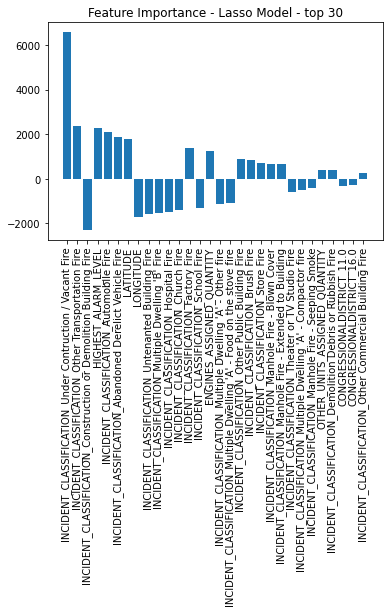

In [76]:
# feature importance, only show the top 30 features
print('Lasso Feature Importance - top 30:')
importance_lasso_abs = np.abs(importance_lasso)
importance_lasso_idx = np.argsort(importance_lasso_abs)[::-1]
for i in range(30):
    print(f'Feature {i}: {X3.columns[importance_lasso_idx[i]]}, Score: {importance_lasso[importance_lasso_idx[i]]:.5f}')

# plot feature importance
pyplot.bar(range(30), importance_lasso[importance_lasso_idx[:30]])
pyplot.xticks(range(30), X3.columns[importance_lasso_idx[:30]], rotation='vertical')
pyplot.title('Feature Importance - Lasso Model - top 30')
pyplot.show()

#### Use PCA to reduce dimensionality, then do the prediction

In [77]:
len(importance_lasso)

55

In [78]:
# there are 54 columns, we can use PCA to reduce the dimensionality

# first scale the data
scaler = preprocessing.StandardScaler()
X3_scaled = scaler.fit_transform(X3)


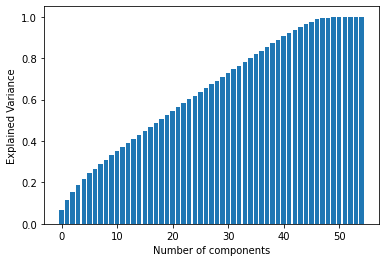

In [79]:
# see the explained variance ratio
pca = PCA(X3_scaled.shape[1])
X3_pca = pca.fit_transform(X3_scaled)
eigenvalues = pca.explained_variance_ratio_

n = 55
plt.bar(np.arange(n), eigenvalues[:n].cumsum())
plt.xlabel("Number of components")
plt.ylabel("Explained Variance")
plt.show()

In [80]:
P = PCA(n_components=0.8)

X3_P = P.fit_transform(X3_scaled)

print('Original number of features:', X3_scaled.shape[1])
print('Reduced number of features:', X3_P.shape[1])

Original number of features: 55
Reduced number of features: 35


In [81]:
# try linear regression to do the prediction
X_train, X_test, y_train, y_test = train_test_split(X3_P, y, test_size=0.2, random_state=123)

In [82]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

r2_lr = r2_score(y_test, y_pred_lr)
print('R2 of Linear Regression Prediction:', r2_lr)

R2 of Linear Regression Prediction: 0.42791222982263555


In [83]:
# try tree
tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

r2_tree = r2_score(y_test, y_pred_tree)
print('R2 of Decision Tree Prediction:', r2_tree)

R2 of Decision Tree Prediction: -0.26743152995141406


## try partly one-hot encoding, and partly label encoding

In [84]:
X4 = X.copy()
# for highest alarm level, we still use ordinal values
X4['HIGHEST_ALARM_LEVEL'] = X4['HIGHEST_ALARM_LEVEL'].replace(alarm_level_mapping)
X4['HIGHEST_ALARM_LEVEL'] = X4['HIGHEST_ALARM_LEVEL'].astype(int)

In [85]:
# use LabelEncoder for CONGRESSIONALDISTRICT, ALARM_SOURCE_DESCRIPTION_TX, INCIDENT_CLASSIFICATION_GROUP
# use OneHotEncoder for INCIDENT_BOROUGH, INCIDENT_CLASSIFICATION

# Label Encode
le4 = preprocessing.LabelEncoder()
X4['CONGRESSIONALDISTRICT'] = le4.fit_transform(X4['CONGRESSIONALDISTRICT'])
# OneHot
onehotencoder4 = preprocessing.OneHotEncoder()
X4_encoded = onehotencoder4.fit_transform(X4[['INCIDENT_CLASSIFICATION']]).toarray()
X4_encoded = pd.DataFrame(X4_encoded, columns=onehotencoder4.get_feature_names_out(['INCIDENT_CLASSIFICATION']))

X4.reset_index(drop=True, inplace=True)
X4_encoded.reset_index(drop=True, inplace=True)

X4 = pd.concat([X4, X4_encoded], axis=1)
X4 = X4.drop(['INCIDENT_CLASSIFICATION'], axis=1)

X4

,CONGRESSIONALDISTRICT,HIGHEST_ALARM_LEVEL,DISPATCH_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,ENGINES_ASSIGNED_QUANTITY,LADDERS_ASSIGNED_QUANTITY,OTHER_UNITS_ASSIGNED_QUANTITY,LATITUDE,LONGITUDE,POP100,MaxTemperature,AvgTemperature,Precipitation,weekday,hour,INCIDENT_CLASSIFICATION_Abandoned Derelict Vehicle Fire,INCIDENT_CLASSIFICATION_Automobile Fire,INCIDENT_CLASSIFICATION_Brush Fire,INCIDENT_CLASSIFICATION_Church Fire,INCIDENT_CLASSIFICATION_Construction or Demolition Building Fire,INCIDENT_CLASSIFICATION_Demolition Debris or Rubbish Fire,INCIDENT_CLASSIFICATION_Factory Fire,INCIDENT_CLASSIFICATION_Hospital Fire,INCIDENT_CLASSIFICATION_Manhole Fire - Blown Cover,INCIDENT_CLASSIFICATION_Manhole Fire - Extended to Building,INCIDENT_CLASSIFICATION_Manhole Fire - Other,INCIDENT_CLASSIFICATION_Manhole Fire - Seeping Smoke,INCIDENT_CLASSIFICATION_Maritime Fire,INCIDENT_CLASSIFICATION_Multiple Dwelling 'A' - Compactor fire,INCIDENT_CLASSIFICATION_Multiple Dwelling 'A' - Food on the stove fire,INCIDENT_CLASSIFICATION_Multiple Dwelling 'A' - Other fire,INCIDENT_CLASSIFICATION_Multiple Dwelling 'B' Fire,INCIDENT_CLASSIFICATION_Other Commercial Building Fire,INCIDENT_CLASSIFICATION_Other Public Building Fire,INCIDENT_CLASSIFICATION_Other Transportation Fire,INCIDENT_CLASSIFICATION_Private Dwelling Fire,INCIDENT_CLASSIFICATION_School Fire,INCIDENT_CLASSIFICATION_Store Fire,INCIDENT_CLASSIFICATION_Theater or TV Studio Fire,INCIDENT_CLASSIFICATION_Transit System - NonStructural,INCIDENT_CLASSIFICATION_Transit System - Structural,INCIDENT_CLASSIFICATION_Under Contruction / Vacant Fire,INCIDENT_CLASSIFICATION_Untenanted Building Fire
0,8,1,38.0,187.0,1.0,1.0,0.0,40.729553,-73.989900,215.929626,88,79.5,0.000,5.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8,1,24.0,149.0,3.0,2.0,1.0,40.729553,-73.989900,215.929626,68,66.0,0.000,3.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8,1,37.0,85.0,4.0,2.0,1.0,40.729553,-73.989900,215.929626,33,27.0,0.000,4.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8,1,61.0,267.0,1.0,1.0,0.0,40.729553,-73.989900,215.929626,61,52.0,0.005,1.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8,1,19.0,109.0,4.0,2.0,1.0,40.729553,-73.989900,215.929626,45,41.0,0.370,4.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96684,2,1,37.0,333.0,1.0,0.0,0.0,40.716017,-73.886351,2.001191,46,41.0,0.000,5.0,18.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96685,2,1,32.0,316.0,1.0,0.0,0.0,40.743107,-73.815676,7.540075,87,80.0,0.005,5.0,23.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96686,9,1,50.0,326.0,1.0,1.0,0.0,40.789511,-73.937502,0.000000,63,61.0,0.840,4.0,19.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96687,7,1,38.0,218.0,4.0,2.0,1.0,40.541210,-74.155249,33.057411,85,75.5,0.000,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


CART (Decision Tree) Feature Importance - top 30:
Feature 0: ENGINES_ASSIGNED_QUANTITY, Score: 0.44670
Feature 1: OTHER_UNITS_ASSIGNED_QUANTITY, Score: 0.20496
Feature 2: LATITUDE, Score: 0.07863
Feature 3: POP100, Score: 0.07304
Feature 4: HIGHEST_ALARM_LEVEL, Score: 0.03768
Feature 5: LONGITUDE, Score: 0.02855
Feature 6: INCIDENT_TRAVEL_TM_SECONDS_QY, Score: 0.02156
Feature 7: hour, Score: 0.02083
Feature 8: LADDERS_ASSIGNED_QUANTITY, Score: 0.02067
Feature 9: DISPATCH_RESPONSE_SECONDS_QY, Score: 0.01997
Feature 10: MaxTemperature, Score: 0.01074
Feature 11: AvgTemperature, Score: 0.00913
Feature 12: Precipitation, Score: 0.00423
Feature 13: CONGRESSIONALDISTRICT, Score: 0.00383
Feature 14: weekday, Score: 0.00381
Feature 15: INCIDENT_CLASSIFICATION_Private Dwelling Fire, Score: 0.00219
Feature 16: INCIDENT_CLASSIFICATION_Multiple Dwelling 'A' - Other fire, Score: 0.00194
Feature 17: INCIDENT_CLASSIFICATION_Automobile Fire, Score: 0.00172
Feature 18: INCIDENT_CLASSIFICATION_Under Con

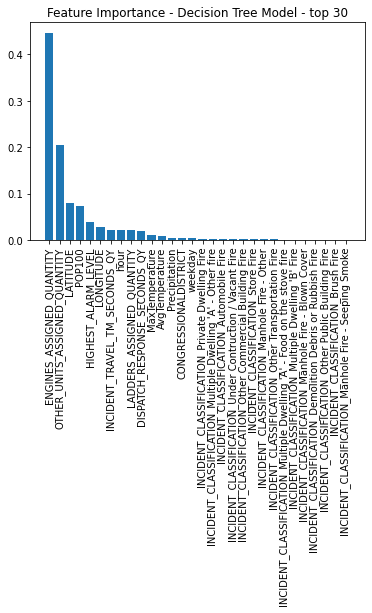

In [86]:
# first, try some tree-based models
# decision tree
model_CART_4 = DecisionTreeRegressor()
model_CART_4.fit(X4, y)
importance_CART_4 = model_CART_4.feature_importances_

# summarize feature importance, only show the top 30 features
print('CART (Decision Tree) Feature Importance - top 30:')
importance_CART_4_abs = np.abs(importance_CART_4)
importance_CART_4_idx = np.argsort(importance_CART_4_abs)[::-1]
for i in range(30):
    print(f'Feature {i}: {X4.columns[importance_CART_4_idx[i]]}, Score: {importance_CART_4[importance_CART_4_idx[i]]:.5f}')

# plot feature importance
pyplot.bar(range(30), importance_CART_4[importance_CART_4_idx[:30]])
pyplot.xticks(range(30), X4.columns[importance_CART_4_idx[:30]], rotation='vertical')
pyplot.title('Feature Importance - Decision Tree Model - top 30')
pyplot.show()

Random Forest Feature Importance - top 30:
Feature 0: ENGINES_ASSIGNED_QUANTITY, Score: 0.47190
Feature 1: OTHER_UNITS_ASSIGNED_QUANTITY, Score: 0.15204
Feature 2: LATITUDE, Score: 0.07424
Feature 3: LONGITUDE, Score: 0.03620
Feature 4: HIGHEST_ALARM_LEVEL, Score: 0.03205
Feature 5: INCIDENT_TRAVEL_TM_SECONDS_QY, Score: 0.02895
Feature 6: hour, Score: 0.02613
Feature 7: POP100, Score: 0.02309
Feature 8: INCIDENT_CLASSIFICATION_Other Public Building Fire, Score: 0.02081
Feature 9: weekday, Score: 0.02018
Feature 10: LADDERS_ASSIGNED_QUANTITY, Score: 0.01949
Feature 11: MaxTemperature, Score: 0.01874
Feature 12: AvgTemperature, Score: 0.01699
Feature 13: DISPATCH_RESPONSE_SECONDS_QY, Score: 0.01377
Feature 14: CONGRESSIONALDISTRICT, Score: 0.00904
Feature 15: Precipitation, Score: 0.00711
Feature 16: INCIDENT_CLASSIFICATION_Store Fire, Score: 0.00568
Feature 17: INCIDENT_CLASSIFICATION_Other Commercial Building Fire, Score: 0.00378
Feature 18: INCIDENT_CLASSIFICATION_Under Contruction / 

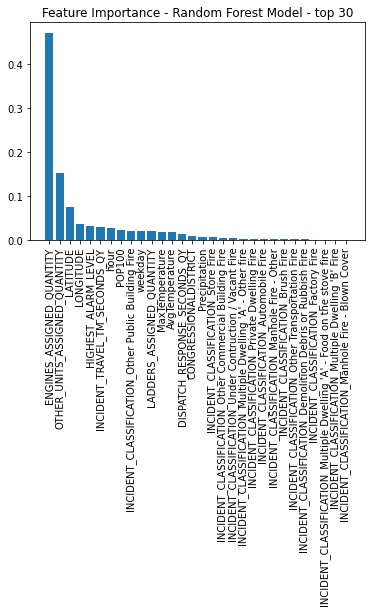

In [87]:
# random forest
model_rf_4 = RandomForestRegressor()
model_rf_4.fit(X4, y)
importance_rf_4 = model_rf_4.feature_importances_

# summarize feature importance, only show the top 30 features
print('Random Forest Feature Importance - top 30:')
importance_rf_4_abs = np.abs(importance_rf_4)
importance_rf_4_idx = np.argsort(importance_rf_4_abs)[::-1]
for i in range(30):
    print(f'Feature {i}: {X4.columns[importance_rf_4_idx[i]]}, Score: {importance_rf_4[importance_rf_4_idx[i]]:.5f}')

# plot feature importance
pyplot.bar(range(30), importance_rf_4[importance_rf_4_idx[:30]])
pyplot.xticks(range(30), X4.columns[importance_rf_4_idx[:30]], rotation='vertical')
pyplot.title('Feature Importance - Random Forest Model - top 30')
pyplot.show()


# plot feature importance
pyplot.barh(range(30), importance_rf_4[importance_rf_4_idx[:30]])
pyplot.yticks(range(30), X4.columns[importance_rf_4_idx[:30]])
pyplot.title('Feature Importance - Random Forest Model - top 30')
pyplot.show()

XGBoost Feature Importance - top 30:
Feature 0: ENGINES_ASSIGNED_QUANTITY, Score: 0.30684
Feature 1: HIGHEST_ALARM_LEVEL, Score: 0.13919
Feature 2: OTHER_UNITS_ASSIGNED_QUANTITY, Score: 0.10717
Feature 3: weekday, Score: 0.05736
Feature 4: INCIDENT_CLASSIFICATION_Demolition Debris or Rubbish Fire, Score: 0.04716
Feature 5: LATITUDE, Score: 0.03712
Feature 6: INCIDENT_CLASSIFICATION_Multiple Dwelling 'A' - Other fire, Score: 0.02558
Feature 7: LONGITUDE, Score: 0.02536
Feature 8: INCIDENT_CLASSIFICATION_Automobile Fire, Score: 0.02458
Feature 9: hour, Score: 0.02380
Feature 10: INCIDENT_CLASSIFICATION_Multiple Dwelling 'A' - Food on the stove fire, Score: 0.02035
Feature 11: Precipitation, Score: 0.01926
Feature 12: AvgTemperature, Score: 0.01633
Feature 13: INCIDENT_CLASSIFICATION_Under Contruction / Vacant Fire, Score: 0.01240
Feature 14: LADDERS_ASSIGNED_QUANTITY, Score: 0.01173
Feature 15: DISPATCH_RESPONSE_SECONDS_QY, Score: 0.01103
Feature 16: INCIDENT_CLASSIFICATION_Factory Fire,

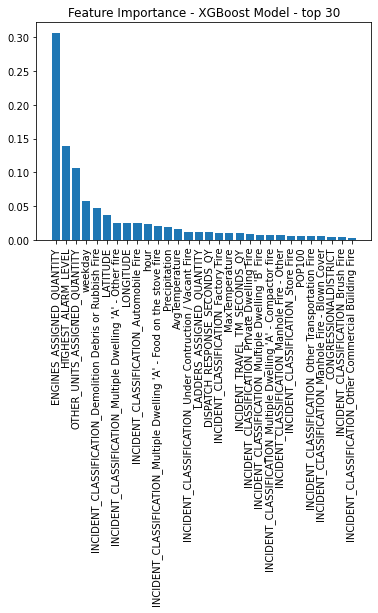

In [88]:
# XGBoost
model_xgb_4 = XGBRegressor()
model_xgb_4.fit(X4, y)
importance_xgb_4 = model_xgb_4.feature_importances_

# summarize feature importance, only show the top 30 features
print('XGBoost Feature Importance - top 30:')
importance_xgb_4_abs = np.abs(importance_xgb_4)
importance_xgb_4_idx = np.argsort(importance_xgb_4_abs)[::-1]
for i in range(30):
    print(f'Feature {i}: {X4.columns[importance_xgb_4_idx[i]]}, Score: {importance_xgb_4[importance_xgb_4_idx[i]]:.5f}')

# plot feature importance
pyplot.bar(range(30), importance_xgb_4[importance_xgb_4_idx[:30]])
pyplot.xticks(range(30), X4.columns[importance_xgb_4_idx[:30]], rotation='vertical')
pyplot.title('Feature Importance - XGBoost Model - top 30')
pyplot.show()


Linear Regression Feature Importance - top 30:
Feature 0: INCIDENT_CLASSIFICATION_Under Contruction / Vacant Fire, Score: 6453.36659
Feature 1: INCIDENT_CLASSIFICATION_Construction or Demolition Building Fire, Score: -2768.15917
Feature 2: LATITUDE, Score: 2439.01858
Feature 3: HIGHEST_ALARM_LEVEL, Score: 2278.14087
Feature 4: INCIDENT_CLASSIFICATION_Other Transportation Fire, Score: 2183.08928
Feature 5: INCIDENT_CLASSIFICATION_Untenanted Building Fire, Score: -2160.78081
Feature 6: INCIDENT_CLASSIFICATION_Automobile Fire, Score: 1872.84420
Feature 7: INCIDENT_CLASSIFICATION_Multiple Dwelling 'B' Fire, Score: -1750.73587
Feature 8: INCIDENT_CLASSIFICATION_Abandoned Derelict Vehicle Fire, Score: 1732.84336
Feature 9: INCIDENT_CLASSIFICATION_Hospital Fire, Score: -1713.40266
Feature 10: INCIDENT_CLASSIFICATION_Church Fire, Score: -1609.43700
Feature 11: INCIDENT_CLASSIFICATION_Theater or TV Studio Fire, Score: -1485.20449
Feature 12: INCIDENT_CLASSIFICATION_School Fire, Score: -1484.410

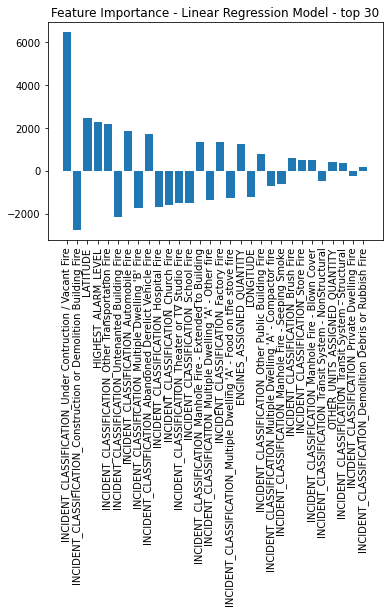

In [89]:
# Next, try some non-tree-based models
# try linear regression to see feature importance
model_lr4 = LinearRegression()
model_lr4.fit(X4, y)
importance_lr4 = model_lr4.coef_

# feature importance, only show the top 30 features
print('Linear Regression Feature Importance - top 30:')
importance_lr4_abs = np.abs(importance_lr4)
importance_lr4_idx = np.argsort(importance_lr4_abs)[::-1]
for i in range(30):
    print(f'Feature {i}: {X4.columns[importance_lr4_idx[i]]}, Score: {importance_lr4[importance_lr4_idx[i]]:.5f}')

# plot feature importance
pyplot.bar(range(30), importance_lr4[importance_lr4_idx[:30]])
pyplot.xticks(range(30), X4.columns[importance_lr4_idx[:30]], rotation='vertical')
pyplot.title('Feature Importance - Linear Regression Model - top 30')
pyplot.show()

Lasso Feature Importance - top 30:
Feature 0: INCIDENT_CLASSIFICATION_Under Contruction / Vacant Fire, Score: 6586.81802
Feature 1: INCIDENT_CLASSIFICATION_Other Transportation Fire, Score: 2369.45162
Feature 2: LATITUDE, Score: 2361.25761
Feature 3: HIGHEST_ALARM_LEVEL, Score: 2274.83083
Feature 4: INCIDENT_CLASSIFICATION_Construction or Demolition Building Fire, Score: -2260.08451
Feature 5: INCIDENT_CLASSIFICATION_Automobile Fire, Score: 2081.88706
Feature 6: INCIDENT_CLASSIFICATION_Abandoned Derelict Vehicle Fire, Score: 1892.70215
Feature 7: INCIDENT_CLASSIFICATION_Untenanted Building Fire, Score: -1625.10374
Feature 8: INCIDENT_CLASSIFICATION_Multiple Dwelling 'B' Fire, Score: -1535.22408
Feature 9: INCIDENT_CLASSIFICATION_Hospital Fire, Score: -1485.20743
Feature 10: INCIDENT_CLASSIFICATION_Factory Fire, Score: 1406.35402
Feature 11: INCIDENT_CLASSIFICATION_Church Fire, Score: -1359.97667
Feature 12: INCIDENT_CLASSIFICATION_School Fire, Score: -1261.61644
Feature 13: ENGINES_ASS

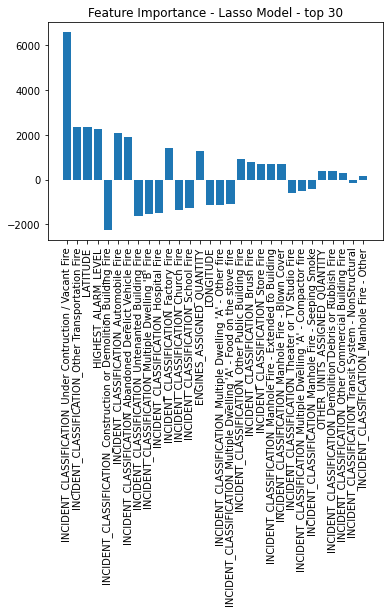

In [90]:
# use Lasso to see feature importance
model_lasso4 = Lasso(alpha=0.1)
model_lasso4.fit(X4, y)
importance_lasso4 = model_lasso4.coef_

# feature importance, only show the top 30 features
print('Lasso Feature Importance - top 30:')
importance_lasso4_abs = np.abs(importance_lasso4)
importance_lasso4_idx = np.argsort(importance_lasso4_abs)[::-1]
for i in range(30):
    print(f'Feature {i}: {X4.columns[importance_lasso4_idx[i]]}, Score: {importance_lasso4[importance_lasso4_idx[i]]:.5f}')

# plot feature importance
pyplot.bar(range(30), importance_lasso4[importance_lasso4_idx[:30]])
pyplot.xticks(range(30), X4.columns[importance_lasso4_idx[:30]], rotation='vertical')
pyplot.title('Feature Importance - Lasso Model - top 30')
pyplot.show()

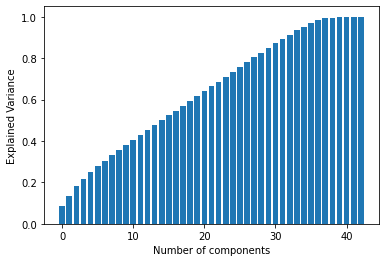

In [91]:
# PCA
scaler4 = preprocessing.StandardScaler()
X4_scaled = scaler4.fit_transform(X4)

pca4 = PCA(X4_scaled.shape[1])
X4_pca = pca4.fit_transform(X4_scaled)
eigenvalues4 = pca4.explained_variance_ratio_

n = X4_scaled.shape[1]
plt.bar(np.arange(n), eigenvalues4.cumsum())
plt.xlabel("Number of components")
plt.ylabel("Explained Variance")
plt.show()


In [92]:
P4 = PCA(n_components=0.8)
X4_P = P4.fit_transform(X4_scaled)
print('Original number of features:', X4_scaled.shape[1])
print('Reduced number of features (explained variance ratio > 0.8):', X4_P.shape[1])

Original number of features: 43
Reduced number of features (explained variance ratio > 0.8): 28


In [93]:
X4

,CONGRESSIONALDISTRICT,HIGHEST_ALARM_LEVEL,DISPATCH_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,ENGINES_ASSIGNED_QUANTITY,LADDERS_ASSIGNED_QUANTITY,OTHER_UNITS_ASSIGNED_QUANTITY,LATITUDE,LONGITUDE,POP100,MaxTemperature,AvgTemperature,Precipitation,weekday,hour,INCIDENT_CLASSIFICATION_Abandoned Derelict Vehicle Fire,INCIDENT_CLASSIFICATION_Automobile Fire,INCIDENT_CLASSIFICATION_Brush Fire,INCIDENT_CLASSIFICATION_Church Fire,INCIDENT_CLASSIFICATION_Construction or Demolition Building Fire,INCIDENT_CLASSIFICATION_Demolition Debris or Rubbish Fire,INCIDENT_CLASSIFICATION_Factory Fire,INCIDENT_CLASSIFICATION_Hospital Fire,INCIDENT_CLASSIFICATION_Manhole Fire - Blown Cover,INCIDENT_CLASSIFICATION_Manhole Fire - Extended to Building,INCIDENT_CLASSIFICATION_Manhole Fire - Other,INCIDENT_CLASSIFICATION_Manhole Fire - Seeping Smoke,INCIDENT_CLASSIFICATION_Maritime Fire,INCIDENT_CLASSIFICATION_Multiple Dwelling 'A' - Compactor fire,INCIDENT_CLASSIFICATION_Multiple Dwelling 'A' - Food on the stove fire,INCIDENT_CLASSIFICATION_Multiple Dwelling 'A' - Other fire,INCIDENT_CLASSIFICATION_Multiple Dwelling 'B' Fire,INCIDENT_CLASSIFICATION_Other Commercial Building Fire,INCIDENT_CLASSIFICATION_Other Public Building Fire,INCIDENT_CLASSIFICATION_Other Transportation Fire,INCIDENT_CLASSIFICATION_Private Dwelling Fire,INCIDENT_CLASSIFICATION_School Fire,INCIDENT_CLASSIFICATION_Store Fire,INCIDENT_CLASSIFICATION_Theater or TV Studio Fire,INCIDENT_CLASSIFICATION_Transit System - NonStructural,INCIDENT_CLASSIFICATION_Transit System - Structural,INCIDENT_CLASSIFICATION_Under Contruction / Vacant Fire,INCIDENT_CLASSIFICATION_Untenanted Building Fire
0,8,1,38.0,187.0,1.0,1.0,0.0,40.729553,-73.989900,215.929626,88,79.5,0.000,5.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8,1,24.0,149.0,3.0,2.0,1.0,40.729553,-73.989900,215.929626,68,66.0,0.000,3.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8,1,37.0,85.0,4.0,2.0,1.0,40.729553,-73.989900,215.929626,33,27.0,0.000,4.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8,1,61.0,267.0,1.0,1.0,0.0,40.729553,-73.989900,215.929626,61,52.0,0.005,1.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8,1,19.0,109.0,4.0,2.0,1.0,40.729553,-73.989900,215.929626,45,41.0,0.370,4.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96684,2,1,37.0,333.0,1.0,0.0,0.0,40.716017,-73.886351,2.001191,46,41.0,0.000,5.0,18.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96685,2,1,32.0,316.0,1.0,0.0,0.0,40.743107,-73.815676,7.540075,87,80.0,0.005,5.0,23.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96686,9,1,50.0,326.0,1.0,1.0,0.0,40.789511,-73.937502,0.000000,63,61.0,0.840,4.0,19.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96687,7,1,38.0,218.0,4.0,2.0,1.0,40.541210,-74.155249,33.057411,85,75.5,0.000,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
X4_reset = X4.reset_index(drop=True)
ResolutionTime_reset = Dispatch3.ResolutionTime.reset_index(drop=True)

# Concatenating along the columns
data_X4 = pd.concat([X4_reset, ResolutionTime_reset], axis=1)



In [46]:
data_X4

,CONGRESSIONALDISTRICT,HIGHEST_ALARM_LEVEL,DISPATCH_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,ENGINES_ASSIGNED_QUANTITY,LADDERS_ASSIGNED_QUANTITY,OTHER_UNITS_ASSIGNED_QUANTITY,LATITUDE,LONGITUDE,POP100,MaxTemperature,AvgTemperature,Precipitation,weekday,hour,INCIDENT_CLASSIFICATION_Abandoned Derelict Vehicle Fire,INCIDENT_CLASSIFICATION_Automobile Fire,INCIDENT_CLASSIFICATION_Brush Fire,INCIDENT_CLASSIFICATION_Church Fire,INCIDENT_CLASSIFICATION_Construction or Demolition Building Fire,INCIDENT_CLASSIFICATION_Demolition Debris or Rubbish Fire,INCIDENT_CLASSIFICATION_Factory Fire,INCIDENT_CLASSIFICATION_Hospital Fire,INCIDENT_CLASSIFICATION_Manhole Fire - Blown Cover,INCIDENT_CLASSIFICATION_Manhole Fire - Extended to Building,INCIDENT_CLASSIFICATION_Manhole Fire - Other,INCIDENT_CLASSIFICATION_Manhole Fire - Seeping Smoke,INCIDENT_CLASSIFICATION_Maritime Fire,INCIDENT_CLASSIFICATION_Multiple Dwelling 'A' - Compactor fire,INCIDENT_CLASSIFICATION_Multiple Dwelling 'A' - Food on the stove fire,INCIDENT_CLASSIFICATION_Multiple Dwelling 'A' - Other fire,INCIDENT_CLASSIFICATION_Multiple Dwelling 'B' Fire,INCIDENT_CLASSIFICATION_Other Commercial Building Fire,INCIDENT_CLASSIFICATION_Other Public Building Fire,INCIDENT_CLASSIFICATION_Other Transportation Fire,INCIDENT_CLASSIFICATION_Private Dwelling Fire,INCIDENT_CLASSIFICATION_School Fire,INCIDENT_CLASSIFICATION_Store Fire,INCIDENT_CLASSIFICATION_Theater or TV Studio Fire,INCIDENT_CLASSIFICATION_Transit System - NonStructural,INCIDENT_CLASSIFICATION_Transit System - Structural,INCIDENT_CLASSIFICATION_Under Contruction / Vacant Fire,INCIDENT_CLASSIFICATION_Untenanted Building Fire,ResolutionTime
0,8,1,38.0,187.0,1.0,1.0,0.0,40.729553,-73.989900,215.929626,88,79.5,0.000,5.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2551.0
1,8,1,24.0,149.0,3.0,2.0,1.0,40.729553,-73.989900,215.929626,68,66.0,0.000,3.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,967.0
2,8,1,37.0,85.0,4.0,2.0,1.0,40.729553,-73.989900,215.929626,33,27.0,0.000,4.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1746.0
3,8,1,61.0,267.0,1.0,1.0,0.0,40.729553,-73.989900,215.929626,61,52.0,0.005,1.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,372.0
4,8,1,19.0,109.0,4.0,2.0,1.0,40.729553,-73.989900,215.929626,45,41.0,0.370,4.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1300.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96684,2,1,37.0,333.0,1.0,0.0,0.0,40.716017,-73.886351,2.001191,46,41.0,0.000,5.0,18.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,971.0
96685,2,1,32.0,316.0,1.0,0.0,0.0,40.743107,-73.815676,7.540075,87,80.0,0.005,5.0,23.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,319.0
96686,9,1,50.0,326.0,1.0,1.0,0.0,40.789511,-73.937502,0.000000,63,61.0,0.840,4.0,19.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2768.0
96687,7,1,38.0,218.0,4.0,2.0,1.0,40.541210,-74.155249,33.057411,85,75.5,0.000,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4270.0


In [47]:
# Saving to CSV
data_X4.to_csv("data_X4.csv", index=False)